**Real vs Fake Images Detection with ELA(Error Level Analysis) and CNN**

For more information, checkout this repo [https://github.com/agusgun/FakeImageDetector](http://) 

In [ ]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping


In [ ]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download ayan2809/invoices-real-and-forged

 63% 33.0M/52.3M [00:01<00:00, 41.2MB/s]
100% 52.3M/52.3M [00:01<00:00, 50.9MB/s]


In [ ]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

In [ ]:
! unzip invoices-real-and-forged.zip

Archive:  invoices-real-and-forged.zip
  inflating: Invoices/Forged/0000137486.jpg  
  inflating: Invoices/Forged/0000192502.jpg  
  inflating: Invoices/Forged/0000226471.jpg  
  inflating: Invoices/Forged/0000227351.jpg  
  inflating: Invoices/Forged/0000333206.jpg  
  inflating: Invoices/Forged/0000542607.jpg  
  inflating: Invoices/Forged/0001136788.jpg  
  inflating: Invoices/Forged/0001219743.jpg  
  inflating: Invoices/Forged/0001219844.jpg  
  inflating: Invoices/Forged/0001233629.jpg  
  inflating: Invoices/Forged/0001453135.jpg  
  inflating: Invoices/Forged/0011519293.jpg  
  inflating: Invoices/Forged/0011929750.jpg  
  inflating: Invoices/Forged/0011929754.jpg  
  inflating: Invoices/Forged/0011930170.jpg  
  inflating: Invoices/Forged/0011991025.jpg  
  inflating: Invoices/Forged/0012179618.jpg  
  inflating: Invoices/Forged/0012193483.jpg  
  inflating: Invoices/Forged/0012287015.jpg  
  inflating: Invoices/Forged/0013041942.jpg  
  inflating: Invoices/Forged/0013043203.j

Open a real image

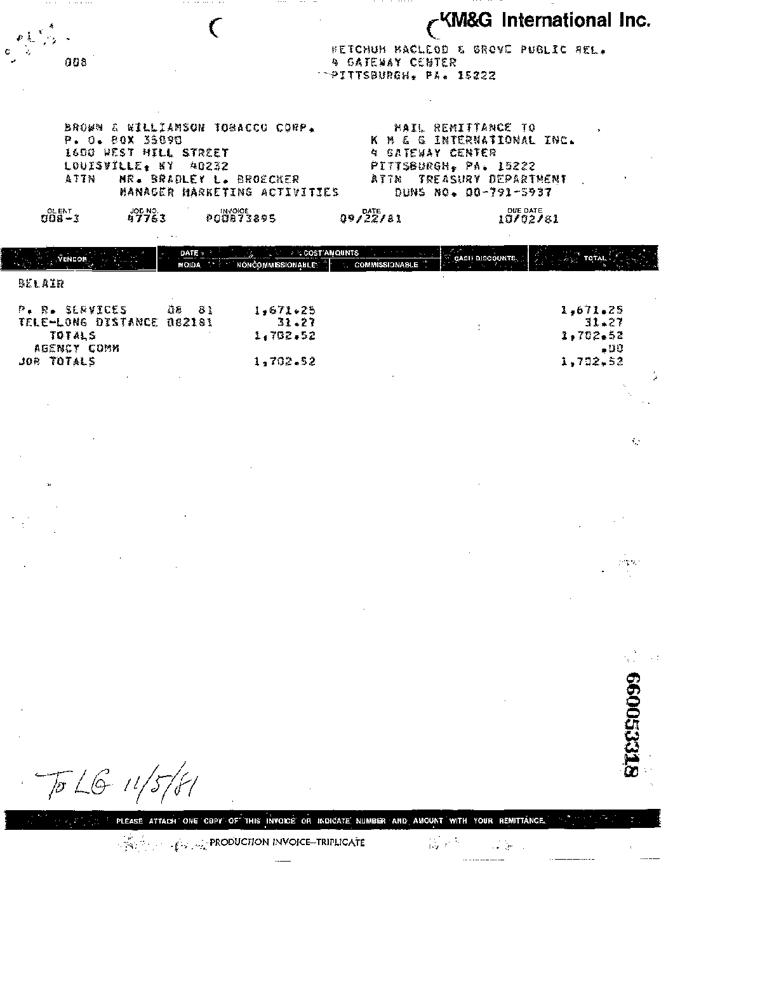

In [ ]:
real_image_path = '/content/Invoices/Real/0000137486.jpg'

Image.open(real_image_path)

After converting to ELA image

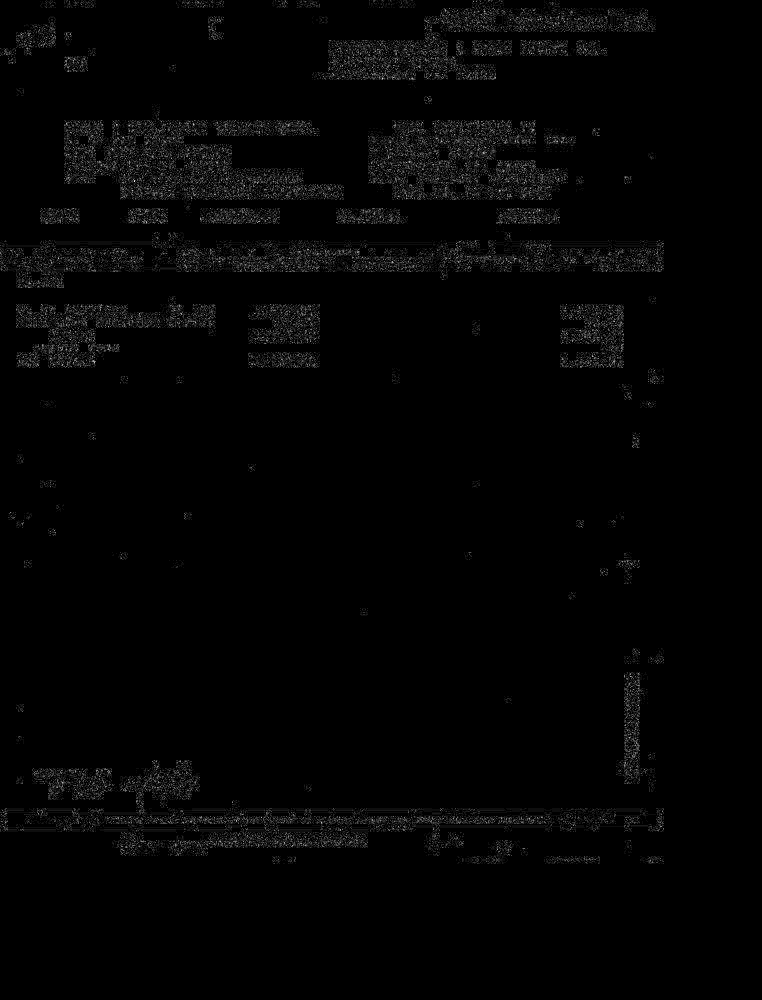

In [ ]:
convert_to_ela_image(real_image_path, 90)

Open a fake image

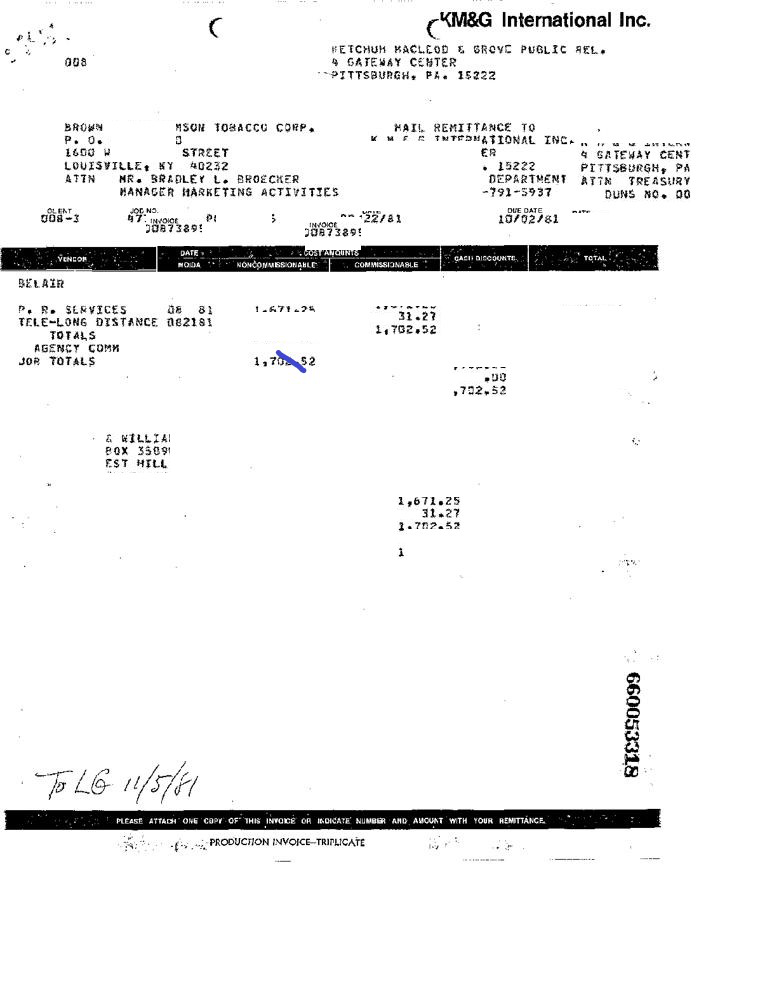

In [ ]:
fake_image_path = '/content/Invoices/Forged/0000137486.jpg'
Image.open(fake_image_path)

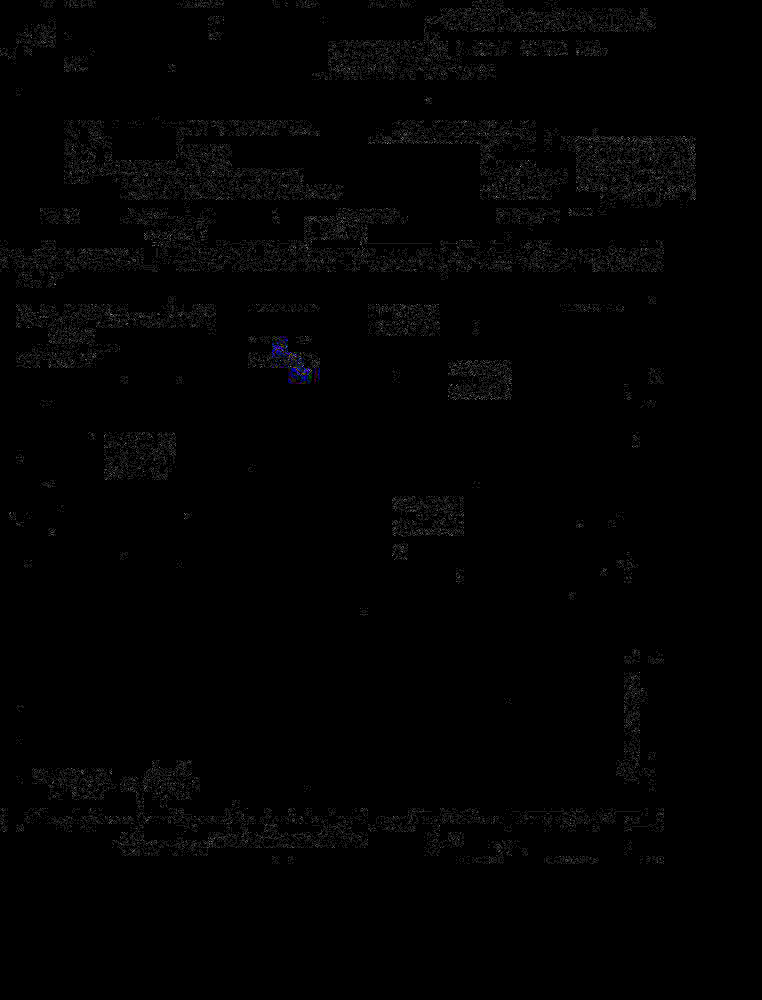

In [ ]:
convert_to_ela_image(fake_image_path, 90)

Dataset Preparation

In [ ]:
image_size = (128, 128)

In [ ]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [ ]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

Au => Total Images 7354, Take 2100 random images from the list
Tp => Total Images 2064

In [ ]:
import random
import os
import numpy as np
path = '/content/Invoices/Real/'

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            # print(full_path)
            # print(prepare_image(full_path))
            f=prepare_image(full_path)
            X.append(f)
            Y.append(1)
            if len(Y) % 100 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:312]
Y = Y[:312]
print(len(X), len(Y))

Processing 100 images
Processing 200 images
Processing 300 images
312 312


In [ ]:
path = '/content/Invoices/Forged/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            f=prepare_image(full_path)
            X.append(f)
            Y.append(0)
            if len(Y) % 100 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 400 images
Processing 500 images
Processing 600 images
624 624


In [ ]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

Train Test split with 80:20 ratio

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

499 499
125 125


CNN Model

In [ ]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dense (Dense)               (None, 256)               29491456  
                                                        

In [ ]:
epochs = 30
batch_size = 32


In [ ]:
init_lr = 1e-4
optimizer = Adam(learning_rate = init_lr, decay = init_lr/epochs)

In [ ]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')

In [ ]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/30
16/16 [==============================] - 50s 3s/step - loss: 0.6928 - accuracy: 0.5090 - val_loss: 0.6858 - val_accuracy: 0.4800
Epoch 2/30
16/16 [==============================] - 50s 3s/step - loss: 0.6761 - accuracy: 0.5090 - val_loss: 0.6773 - val_accuracy: 0.4800
Epoch 3/30
16/16 [==============================] - 48s 3s/step - loss: 0.6579 - accuracy: 0.5391 - val_loss: 0.6598 - val_accuracy: 0.5360
Epoch 4/30
16/16 [==============================] - 48s 3s/step - loss: 0.6220 - accuracy: 0.6754 - val_loss: 0.6220 - val_accuracy: 0.7440
Epoch 5/30
16/16 [==============================] - 48s 3s/step - loss: 0.5792 - accuracy: 0.7776 - val_loss: 0.5915 - val_accuracy: 0.6880
Epoch 6/30
16/16 [==============================] - 50s 3s/step - loss: 0.5542 - accuracy: 0.7435 - val_loss: 0.5507 - val_accuracy: 0.7680
Epoch 7/30
16/16 [==============================] - 48s 3s/step - loss: 0.4989 - accuracy: 0.8196 - val_loss: 0.5472 - val_accuracy: 0.7360
Epoch 8/30
16/16 [==

In [ ]:
model.save('model_invoice_run1.h5')

In [ ]:
hist=

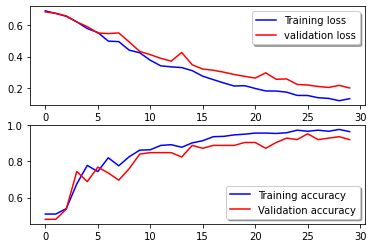

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    


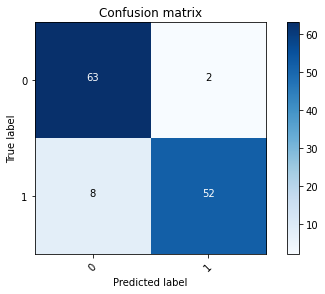

In [ ]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

Prediction

In [ ]:
class_names = ['forged', 'real']

In [ ]:
real_image_path= '/content/0012287015.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: forged Confidence: 98.89


In [ ]:
image = prepare_image(fake_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: fake Confidence: 98.08


In [ ]:
fake_image = os.listdir('/content/Invoices/Forged/')
correct = 0
total = 0
for file_name in fake_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        fake_image_path = os.path.join('/content/Invoices/Forged/', file_name)
        image = prepare_image(fake_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total += 1
        if y_pred_class == 0:
            correct += 1
#             print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

In [ ]:
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 312, Correct: 310, Acc: 99.35897435897436


In [ ]:
real_image = os.listdir('/content/Invoices/Real/')
correct_r = 0
total_r = 0
for file_name in real_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        real_image_path = os.path.join('/content/Invoices/Real/', file_name)
        image = prepare_image(real_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total_r += 1
        if y_pred_class == 1:
            correct_r += 1
#             print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

In [ ]:
correct += correct_r
total += total_r
print(f'Total: {total_r}, Correct: {correct_r}, Acc: {correct_r / total_r * 100.0}')
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 312, Correct: 292, Acc: 93.58974358974359
Total: 624, Correct: 602, Acc: 96.47435897435898
